In [1]:
import brainio

raw_assembly = brainio.get_assembly('dicarlo.muri1320.2023.v1.pico.psth.raw')
print(raw_assembly)

Loading catalog from entrypoints
Loading lookup from /braintree/home/msch/miniconda3/envs/pipeline_analysis/lib/python3.11/site-packages/brainio_dicarlo/lookup.csv
<xarray.NeuronRecordingAssembly 'data' (presentation: 40127, neuroid: 192,
                                        time_bin: 10)>
array([[[0, 0, 0, ..., 0, 2, 1],
        [0, 0, 0, ..., 1, 2, 0],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 4, 3, ..., 1, 1, 1]],

       [[4, 1, 3, ..., 1, 0, 0],
        [2, 0, 3, ..., 0, 0, 0],
        [2, 0, 2, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]],

       [[0, 5, 0, ..., 0, 2, 0],
        [0, 0, 0,

In [2]:
import numpy as np

print(f"unique images: {len(set(raw_assembly['stimulus_id'].values))}")
print(f"time bins: {sorted(set(raw_assembly['time_bin_start_ms'].values))}")
print("repetitions", np.unique(raw_assembly['repetition'].values, return_counts=True))

unique images: 1318
time bins: [70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
repetitions (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17]), array([11532,  7921,  5284,  5272,  3956,  2168,  1324,  1324,  1319,
          10,     3,     2,     2,     2,     2,     2,     2,     2]))


## internal consistency over time

In [3]:
from brainio.assemblies import walk_coords

REPETITION_COORDS = ['repetition', 'eye_h_degrees', 'eye_v_degrees', 'eye_time_ms', 'samp_on_us', 'photodiode_on_us',
                     'session_date_str', 'session_time_str', 'session_datetime', 'intan_session_identifier',
                     'mwk_session_identifier', 'presentation_id', 'stimulus_order_in_trial',
                     'normalizer_assembly_identifier']
""" all the coordinates that are not shared across repeated presentations of the same stimulus """

assembly = raw_assembly


def average_repetitions(assembly):
    repetition_dims = assembly['presentation'].dims
    nonrepetition_coords = [coord for coord, dims, values in walk_coords(assembly)
                            if dims == repetition_dims and coord not in REPETITION_COORDS]
    average = assembly.multi_groupby(nonrepetition_coords).mean(dim=repetition_dims)
    return average

In [4]:
from tqdm import tqdm
from scipy.stats import pearsonr
from numpy.random import RandomState
import pandas as pd

results = []
random_state = RandomState(0)
repetitions = list(sorted(set(raw_assembly['repetition'].values)))

for time_bin_start in tqdm(raw_assembly['time_bin_start_ms'].values, desc='time_bin'):
    bin_assembly = raw_assembly.sel(time_bin_start_ms=time_bin_start).squeeze('time_bin')
    for split in range(10):
        repetitions_half1 = random_state.choice(repetitions, size=len(repetitions) // 2, replace=False)
        half1 = bin_assembly[{'presentation': [repetition in repetitions_half1
                                               for repetition in bin_assembly['repetition'].values]}]
        half2 = bin_assembly[{'presentation': [repetition not in repetitions_half1
                                               for repetition in bin_assembly['repetition'].values]}]
        half1 = average_repetitions(half1)
        half2 = average_repetitions(half2)
        # align halves
        half1 = half1.sortby('stimulus_id')
        half2 = half2.sortby('stimulus_id')
        assert (half1['stimulus_id'].values == half2['stimulus_id'].values).all()
        for neuroid_id in raw_assembly['neuroid_id'].values:
            neuroid_correlation, _ = pearsonr(half1.sel(neuroid_id=neuroid_id).squeeze('neuroid'),
                                              half2.sel(neuroid_id=neuroid_id).squeeze('neuroid'))
            results.append({'time_bin_start': time_bin_start, 'split': split,
                            'neuroid_id': neuroid_id, 'correlation': neuroid_correlation})
results = pd.DataFrame(results)

time_bin: 100%|██████████| 10/10 [05:08<00:00, 30.84s/it]


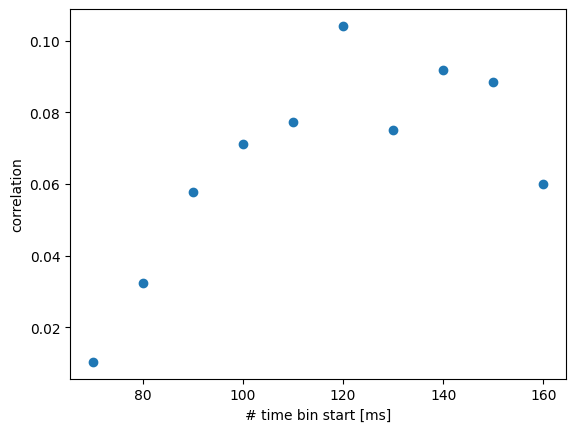

In [5]:
from matplotlib import pyplot

aggregate_results = results.copy()
aggregate_results = aggregate_results.groupby(['time_bin_start', 'neuroid_id']).mean().reset_index()
aggregate_results = aggregate_results.groupby(['time_bin_start']).median('neuroid_id').reset_index()

fig, ax = pyplot.subplots()
ax.scatter(aggregate_results['time_bin_start'], aggregate_results['correlation'])
ax.set_xlabel('# time bin start [ms]')
ax.set_ylabel('correlation')
fig.show()

## average out repetitions and time

In [6]:
assembly = average_repetitions(raw_assembly)
assembly = assembly[{'time_bin': [70 <= start <= 170 for start in assembly['time_bin_start_ms'].values]}]
assembly = assembly.mean('time_bin')
print(assembly)

<xarray.NeuronRecordingAssembly 'data' (presentation: 1320, neuroid: 192)>
array([[0.74333333, 0.57333333, 0.44333333, ..., 0.93666667, 0.84      ,
        0.56      ],
       [0.44827586, 0.33793103, 0.28965517, ..., 0.63448276, 0.6137931 ,
        0.51724138],
       [0.384375  , 0.265625  , 0.259375  , ..., 0.371875  , 0.378125  ,
        0.309375  ],
       ...,
       [0.39032258, 0.28064516, 0.22580645, ..., 0.39354839, 0.38709677,
        0.33225806],
       [0.48064516, 0.34193548, 0.39677419, ..., 0.50645161, 0.50967742,
        0.37419355],
       [0.27741935, 0.16129032, 0.22903226, ..., 0.31935484, 0.31935484,
        0.23548387]])
Coordinates:
  * neuroid                        (neuroid) MultiIndex
  - filter_high                    (neuroid) int64 6000 6000 6000 ... 6000 6000
  - adapter_version                (neuroid) object 'adaptorAIT.v1.2023' ... ...
  - array                          (neuroid) object '6250-002929' ... '6250-0...
  - monkey_directory               (n

## Readout capability

num sites: 100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


   num_sites      mean       std
0          1  0.522272  0.031662
1          5  0.531295  0.050898
2         10  0.559023  0.040092
3         20  0.546441  0.039213
4         40  0.549755  0.040755
5         80  0.519663  0.050275
6        160  0.525347  0.049175


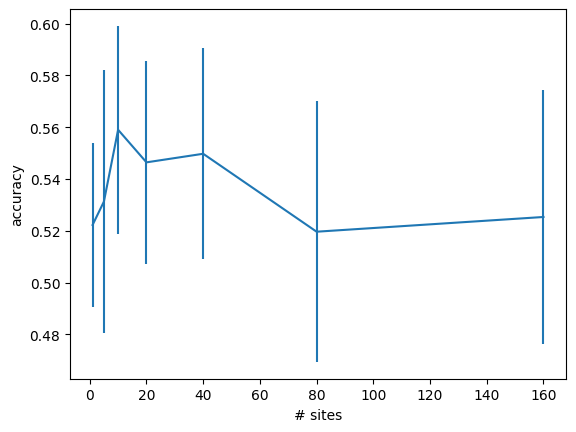

In [7]:
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
from sklearn.linear_model import RidgeClassifierCV
import pandas as pd
from tqdm import tqdm

results = []

random_state = RandomState(0)
for num_sites in tqdm([1, 5, 10, 20, 40, 80, 160], desc='num sites'):
    for split in range(10):
        sites = random_state.choice(assembly['neuroid_id'].values, size=num_sites, replace=False)
        sites_assembly = assembly[{'neuroid': [neuroid_id in sites for neuroid_id in assembly['neuroid_id'].values]}]
        # train/test
        stimulus_ids = assembly['stimulus_id'].values
        train_stimuli, test_stimuli = train_test_split(stimulus_ids, test_size=0.1, random_state=random_state)
        train_assembly = assembly[{'presentation': [stimulus_id in train_stimuli
                                                    for stimulus_id in assembly['stimulus_id'].values]}]
        test_assembly = assembly[{'presentation': [stimulus_id in test_stimuli
                                                   for stimulus_id in assembly['stimulus_id'].values]}]
        # run classifier
        classifier = RidgeClassifierCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10], fit_intercept=True)
        classifier.fit(train_assembly, train_assembly['image_label'])
        test_score = classifier.score(test_assembly, test_assembly['image_label'])
        results.append({'num_sites': num_sites, 'split': split, 'test_score': test_score})
results = pd.DataFrame(results)
results = results.groupby('num_sites') \
    .agg(mean=('test_score', np.mean), std=('test_score', np.std)) \
    .reset_index()
print(results)

fig, ax = pyplot.subplots()
ax.errorbar(results['num_sites'], results['mean'], yerr=results['std'])
ax.set_xlabel('# sites')
ax.set_ylabel('accuracy')
fig.show()